# AI in data science project
## Kaggle competition: LLM Detect AI generated text
### Ensemble model with simple classifiers

Used codes from kaggle: 

https://www.kaggle.com/code/zulqarnainali/explained-llm-model?fbclid=IwAR24MUE-EWqjAZVU6OTuA982bxC0LxA7F2e3CnDEjFmId8u24ik5fFQmHOg

https://www.kaggle.com/code/alexia/kerasnlp-starter-notebook-llm-detect-ai-generate

In [1]:
# Import packages

import numpy as np
import pandas as pd
import os
import gc
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)
from sklearn.feature_extraction.text import TfidfVectorizer
from datasets import Dataset
from transformers import PreTrainedTokenizerFast
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import sys
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report
from sklearn.metrics import roc_curve, auc

In [2]:

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv
/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv
/kaggle/input/llm-detect-ai-generated-text/test_essays.csv
/kaggle/input/llm-detect-ai-generated-text/train_essays.csv
/kaggle/input/daigt-v2-aug/daigt-v2-train-dataset-augmented
/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv


In [3]:
# Import data

test = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')
sub = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv')
org_train = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_essays.csv')
train = pd.read_csv("/kaggle/input/daigt-v2-aug/daigt-v2-train-dataset-augmented", sep=',')
train_prompts = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv')

## Data understanding

In [4]:
# Train prompts used in the original training dataset
print(train_prompts.info())
train_prompts.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   prompt_id     2 non-null      int64 
 1   prompt_name   2 non-null      object
 2   instructions  2 non-null      object
 3   source_text   2 non-null      object
dtypes: int64(1), object(3)
memory usage: 192.0+ bytes
None


,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


In [5]:
# Original training dataset essays
org_train

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0
...,...,...,...,...
1373,fe6ff9a5,1,There has been a fuss about the Elector Colleg...,0
1374,ff669174,0,Limiting car usage has many advantages. Such a...,0
1375,ffa247e0,0,There's a new trend that has been developing f...,0
1376,ffc237e9,0,As we all know cars are a big part of our soci...,0


Text(0.5, 1.0, 'Distribution of Generated Text')

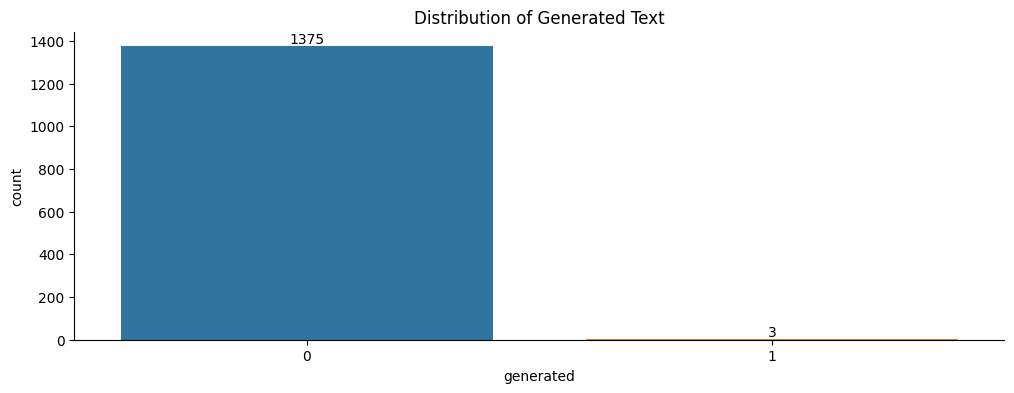

In [6]:
# Distribution of generated - human written essays
f, ax = plt.subplots(figsize=(12, 4))
sns.despine()
ax = sns.countplot(data=org_train, x="generated")

abs_values = org_train['generated'].value_counts().values
ax.bar_label(container=ax.containers[0], labels=abs_values)
ax.set_title("Distribution of Generated Text")

The external dataset: DAIGT V2

name: train

In [7]:
# Different types of prompt names from the external dataset
train["prompt_name"].unique()

array(['Does the electoral college work?',
       '"A Cowboy Who Rode the Waves"', 'Car-free cities',
       'The Face on Mars', 'Facial action coding system',
       'Driverless cars', 'Exploring Venus', 'Phones and driving',
       'Summer projects', 'Mandatory extracurricular activities',
       'Community service', 'Grades for extracurricular activities',
       'Cell phones at school', 'Distance learning',
       'Seeking multiple opinions'], dtype=object)

In [8]:
# The train dataset
train.head()

,text,label,prompt_name,source,RDizzl3_seven
0,"Dear Senator [Name],\n\nI hope this message f...",1,Does the electoral college work?,mistralai/Mistral-7B-Instruct-v0.1,True
1,"Dear Senator [Name],\n\nI am writing to expre...",1,Does the electoral college work?,mistralai/Mistral-7B-Instruct-v0.1,True
2,"Dear Senator,\n\nI am writing to express my v...",1,Does the electoral college work?,mistralai/Mistral-7B-Instruct-v0.1,True
3,The electoral college is a group of electors ...,1,Does the electoral college work?,mistralai/Mistral-7B-Instruct-v0.1,True
4,The cowboy's boots clanked against the wooden...,1,"""A Cowboy Who Rode the Waves""",mistralai/Mistral-7B-Instruct-v0.1,True


In [9]:
# The test dataframe: only contains 3 examples this time
test

,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


In [10]:
# The submission file: format that should be generated at the end
sub

,id,generated
0,0000aaaa,0.1
1,1111bbbb,0.9
2,2222cccc,0.4


<class 'pandas.core.frame.DataFrame'>
Index: 46646 entries, 0 to 1377
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       46646 non-null  object
 1   generated  46646 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


Text(0.5, 1.0, 'Distribution of generated text in all of the labeled data')

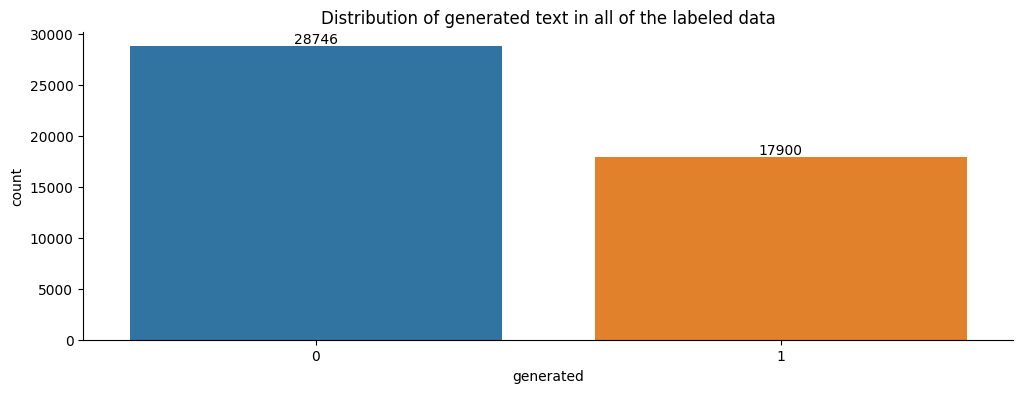

In [11]:
# From now on, we use the train data for model training and validation. 
# First, I need to concatenate the original train data and the external train data.

train.rename(columns = {"label":"generated"}, inplace=True) # rename the label column to generated as in the original data

#concatination
train_final = pd.concat([train[["text", "generated"]], org_train[["text", "generated"]]])
train_final.info()

# visualize distribution of the 2 labels in all of the labeled data
f, ax = plt.subplots(figsize=(12, 4))
sns.despine()
ax = sns.countplot(data=train_final,
                   x="generated")
abs_values = train_final['generated'].value_counts().values
ax.bar_label(container=ax.containers[0], labels=abs_values)
ax.set_title("Distribution of generated text in all of the labeled data")

## 5-fold cross-validation

This is not used in the beginning!

train_index and test_index (numpy arrays): the indices of the train and test set for the given fold.
Each entry gets to be test data only once, so the fold can be assigned to that entry.

In [12]:
#train_final = train_final.reset_index(drop=True) #reset index

In [13]:
# 5-fold cross-validation

#skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # initializing
#for i, (train_index, test_index) in enumerate(skf.split(train_final["text"], train_final["generated"])):
    #print(f"Fold {i}:")
    #print(f"  Train: index={train_index}")
    #print(f"  Test:  index={test_index}")
#print(train_final["generated"].size) # number of all entries
#print(train_index.size) # number of train set
#print(test_index.size) # number of test set

#train_final["fold"]=-1
#for i, (train_index, test_index) in enumerate(skf.split(train_final["text"], train_final["generated"])):
#    train_final.loc[test_index, "fold"] = i # assign fold index to entries
#train_final.head()

In [14]:
# Train and test sets extraction function
#def get_train_test_sets(fold):
#    df_train = train_final[train_final.fold != fold]
#    df_test = train_final[train_final.fold == fold]
#    X_train = df_train["text"]
#    X_test = df_test["text"]
#    y_train = df_train["generated"]
#    y_test = df_test["generated"]
#    return X_train, X_test, y_train, y_test

In [15]:
# extraction of the sets of fold 0
#X_train, X_test, y_train, y_test = get_train_test_sets(fold=0)
#type(X_train)
#type(y_train)

## Train test split

Model training and hyperparameter optimization is done using X_train.

X_test is set aside until model evaluation (unseen data, 20%).


In [13]:
# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(train_final["text"],
                                                    train_final["generated"],
                                                    test_size=0.20,
                                                    random_state=42,
                                                    stratify=train_final["generated"])

In [14]:
X_train.size

37316

In [15]:
X_test.size

9330

## Preprocessing

- tokenization
- TF-IDF vectorization

In [16]:
# Configuration parameters

LOWERCASE = False
VOCAB_SIZE = 30522

In [17]:
# Creating Byte-Pair Encoding tokenizer

raw_tokenizer = Tokenizer(models.BPE(unk_token="[UNK]"))
raw_tokenizer.normalizer = normalizers.Sequence([normalizers.NFC()] + [normalizers.Lowercase()] if LOWERCASE else [])
raw_tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel()

special_tokens = ["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]
trainer = trainers.BpeTrainer(vocab_size=VOCAB_SIZE, special_tokens=special_tokens)
train_dataset = Dataset.from_pandas(pd.DataFrame({'text': X_train, 'generated': y_train}))

def train_corp_iter(): 
    for i in range(0, len(train_dataset), 1000):
        yield train_dataset[i : i + 1000]["text"]
        
raw_tokenizer.train_from_iterator(train_corp_iter(), trainer=trainer) # train the tokenizer
tokenizer = PreTrainedTokenizerFast( # creating another tokenizer using the trained tokenizer
    tokenizer_object=raw_tokenizer,
    unk_token="[UNK]",
    pad_token="[PAD]",
    cls_token="[CLS]",
    sep_token="[SEP]",
    mask_token="[MASK]",
)
tokenized_texts_train = [tokenizer.tokenize(text) for text in tqdm(X_train.tolist())]
tokenized_texts_test = [tokenizer.tokenize(text) for text in tqdm(X_test.tolist())]


  0%|          | 0/37316 [00:00<?, ?it/s]

  0%|          | 0/9330 [00:00<?, ?it/s]

In [19]:
tokenized_texts_train[0] # first dimension: number of texts. Second dimension: tokens in a given text
len(tokenized_texts_train)

37316

In [20]:
len(tokenized_texts_test)

9330

In [21]:
# Convert tokenized texts back to sentences
#tokenized_texts_train_sentences = [' '.join(tokens) for tokens in tokenized_texts_train]
#tokenized_texts_test_sentences = [' '.join(tokens) for tokens in tokenized_texts_test]

# TF-IDF Vectorization
def dummy_fun(doc):
    return doc  

tfidf_vectorizer = TfidfVectorizer(analyzer='word',
                                   tokenizer=dummy_fun,
                                   preprocessor=dummy_fun,
                                   token_pattern=None)
X_train_tfidf = tfidf_vectorizer.fit_transform(tokenized_texts_train)
X_test_tfidf = tfidf_vectorizer.transform(tokenized_texts_test)

In [22]:
X_train_tfidf.shape
#tokenized_texts_train_sentences[0]

(37316, 30007)

In [23]:
X_test_tfidf.shape

(9330, 30007)

## Hyperparameter tuning

In [26]:
# Define classifiers
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
nb_classifier = MultinomialNB(alpha=0.1)
lr_classifier = LogisticRegression()
#svm_classifier = SVC(kernel='linear', probability=True)  # Note: probability=True for VotingClassifier
sgd_classifier= SGDClassifier(max_iter=8000, tol=1e-4, loss="modified_huber") 
p6={'n_iter': 2500,
    'verbose': -1,
    'objective': 'cross_entropy',
    'metric': 'auc',
    'learning_rate': 0.01, 
    'colsample_bytree': 0.78,
    'colsample_bynode': 0.8, 
    'lambda_l1': 4.562963348932286, 
    'lambda_l2': 2.97485, 
    'min_data_in_leaf': 115, 
    'max_depth': 23, 
    'max_bin': 898}
lgbm_classifier=LGBMClassifier(**p6)
cat_classifier=CatBoostClassifier(iterations=2000,
                       verbose=0,
                       l2_leaf_reg=6.6591278779517808,
                       learning_rate=0.1,
                       subsample = 0.4,
                       allow_const_label=True,loss_function = 'CrossEntropy')

# Create a VotingClassifier
ensemble_classifier = VotingClassifier(estimators=[
    ('rf', rf_classifier),
    ('nb', nb_classifier),
    ('lr', lr_classifier),
    #('svm', svm_classifier),
    ('sgd', sgd_classifier),
    ('lgbm',lgbm_classifier), 
    ('cat', cat_classifier)    
], voting='soft', n_jobs=-1)  # 'soft' for probability voting

# Create a pipeline for the ensemble classifier
#ensemble_pipeline = Pipeline([
#    ('tfidf', TfidfVectorizer()),
#    ('ensemble', ensemble_classifier)
#])

In [1]:
# parameter grid
param_dist = {
    'rf__n_estimators': [50,100,200],
    'nb__alpha': [0.1, 0.5],
    'lgbm__learning_rate': [0.01, 0.05] 
}

# Create RandomizedSearchCV with stratified cross-validation splitter
# scoring will be based on roc_auc as in the competition

def stratified_splitter(X, y, n_splits=3, label_to_stratify=None, random_state=42):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    for train_index, test_index in skf.split(X, y):
        yield train_index, test_index

# Create the RandomizedSearchCV object with the custom splitter
cv_splitter = stratified_splitter(X_train_tfidf, y_train, label_to_stratify=y_train, random_state=42)
random_search = RandomizedSearchCV(ensemble_classifier, param_distributions=param_dist,
                                   n_iter=10, scoring='roc_auc', cv=cv_splitter, n_jobs=-1, random_state=42)

# Fit the RandomizedSearchCV
tuning_results = random_search.fit(X_train_tfidf, y_train)

# Best ROC AUC score with the best parameters
print("Best: %f using %s" % (tuning_results.best_score_, tuning_results.best_params_))

NameError: name 'X_train_tfidf' is not defined

In [28]:
# best model
best_model = tuning_results.best_estimator_

# best parameters
print("Best Hyperparameters:", tuning_results.best_params_)

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_estimator_'

In [ ]:
# evaluate the best model on the test set
roc_auc = best_model.score(X_test, y_test)
print("Test Accuracy:", roc_auc)

## Train the model on all training data using the best hyperparameters

In [25]:
# Define classifiers with best parameters
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
nb_classifier = MultinomialNB(alpha=0.1)
lr_classifier = LogisticRegression()
sgd_classifier= SGDClassifier(max_iter=8000, tol=1e-4, loss="modified_huber") 
p6={'n_iter': 2500,
    'verbose': -1,
    'objective': 'cross_entropy',
    'metric': 'auc',
    'learning_rate': 0.01, 
    'colsample_bytree': 0.78,
    'colsample_bynode': 0.8, 
    'lambda_l1': 4.562963348932286, 
    'lambda_l2': 2.97485, 
    'min_data_in_leaf': 115, 
    'max_depth': 23, 
    'max_bin': 898}
lgbm_classifier=LGBMClassifier(**p6)
cat_classifier=CatBoostClassifier(iterations=2000,
                       verbose=0,
                       l2_leaf_reg=6.6591278779517808,
                       learning_rate=0.1,
                       subsample = 0.4,
                       allow_const_label=True,loss_function = 'CrossEntropy')

ensemble_classifier_final = VotingClassifier(estimators=[
    ('rf', rf_classifier),
    ('nb', nb_classifier),
    ('lr', lr_classifier),
    ('sgd', sgd_classifier),
    ('lgbm',lgbm_classifier), 
    ('cat', cat_classifier)    
], voting='soft', n_jobs=-1)

# train classifier
ensemble_classifier_final.fit(X_train_tfidf,y_train)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[LightGBM] [Warning] lambda_l1 is set=4.562963348932286, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.562963348932286
[LightGBM] [Warning] lambda_l2 is set=2.97485, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.97485
[LightGBM] [Warning] min_data_in_leaf is set=115, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=115
[LightGBM] [Warning] num_iterations is set=2500, n_iter=2500 will be ignored. Current value: num_iterations=2500


VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                             ('nb', MultinomialNB(alpha=0.1)),
                             ('lr', LogisticRegression()),
                             ('sgd',
                              SGDClassifier(loss='modified_huber',
                                            max_iter=8000, tol=0.0001)),
                             ('lgbm',
                              LGBMClassifier(colsample_bynode=0.8,
                                             colsample_bytree=0.78,
                                             lambda_l1=4.562963348932286,
                                             lambda_l2=2.97485,
                                             learning_rate=0.01, max_bin=898,
                                             max_depth=23, metric='auc',
                                             min_data_in_leaf=115, n_iter=2500,
                                             objective='cross_entropy',
                                             verbose=-1)),
                             ('cat',
                              <catboost.core.CatBoostClassifier object at 0x7e0ebda6eb90>)],
                 n_jobs=-1, voting='soft')

In [28]:
# predictions on the test set
ensemble_predictions = ensemble_classifier_final.predict(X_test_tfidf)

In [29]:
np.savetxt("y_pred.csv", ensemble_predictions, delimiter=",")

In [30]:
np.savetxt("y_test.csv", y_test, delimiter=",")

## Assess the performance of the ensemble model

1. Accuracy, Precision, Recall, F1 - score
2. Confusion matrix
3. ROC curve, AUC value
4. assessing ensemble diversity -> assess correlation of the models (?)
5. outlier analysis (TF-IDF values, misclassified texts)
6. individual model contributions

Other to dos:
- cross validation -> 5 or 10 fold
- hyper parameter tuning (?) -> GridSearchCV, RandomizedSearchCV
    - Some sources for hyperparameter tuning of ensemble models:
    - https://www.kaggle.com/code/sigmaset/hyperparameter-tuning-ensemble-methods/notebook
    - https://medium.com/mlearning-ai/hyperparameter-tuning-the-weighted-average-ensemble-in-python-cff2100f0832
    - https://www.kaggle.com/code/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy
    
- how to determine ensemble weights
- use other classifiers i.e. KNN classifier, Logistic regression
- parallelization


In [31]:
# ensemble model metrics
accuracy = accuracy_score(y_test, ensemble_predictions)
f1_score = f1_score(y_test, ensemble_predictions)
recall = recall_score(y_test, ensemble_predictions)
precision = precision_score(y_test, ensemble_predictions)
classification_report_str = classification_report(y_test, ensemble_predictions)

print(f'Accuracy: {accuracy}')
print(f'f1 score: {f1_score}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print('Classification Report:')
print(classification_report_str)

Accuracy: 0.9952840300107181
f1 score: 0.9938254280101038
Recall: 0.9891061452513966
Precision: 0.9985899605188945
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      5750
           1       1.00      0.99      0.99      3580

    accuracy                           1.00      9330
   macro avg       1.00      0.99      1.00      9330
weighted avg       1.00      1.00      1.00      9330



In [32]:
ensemble_predictions

array([0, 0, 1, ..., 0, 0, 0])

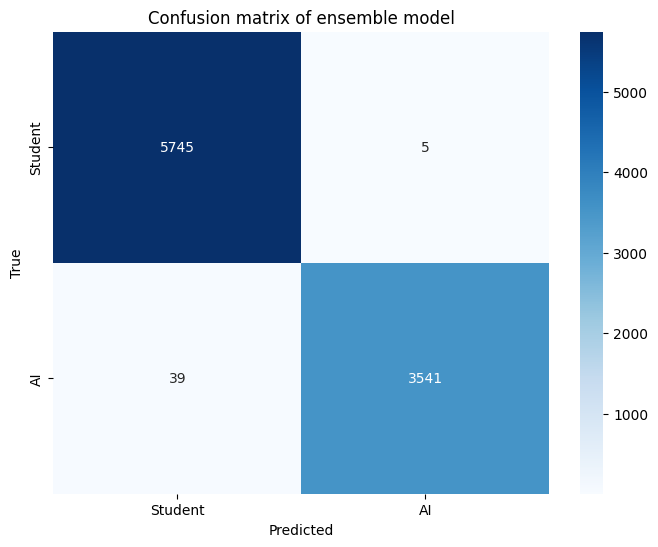

<Figure size 640x480 with 0 Axes>

In [38]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, ensemble_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Student', 'AI'], yticklabels=['Student', 'AI'])
plt.title('Confusion matrix of ensemble model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
plt.savefig('confusion_mx_ensemble.png')

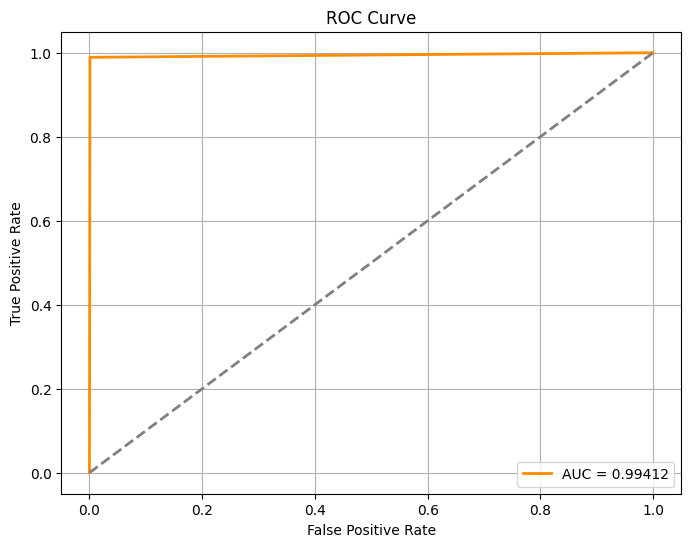

<Figure size 640x480 with 0 Axes>

In [40]:
# ROC curve, AUC value

fpr, tpr, thresholds = roc_curve(y_test, ensemble_predictions, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.5f}')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()
plt.savefig('ROC_ensemble.png')